In [ ]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import math
import ipywidgets as widgets
from ipywidgets import VBox, HBox, interactive
import math
import matplotlib.image as img
import cv2
from IPython.display import clear_output, display
from tkinter import Tk, filedialog
from datetime import datetime
import seaborn as sns

This notebook consists of the following classes:
  
    
    class main
    class subjects
    class session
    class side_cam
    class bottom_cam
    class top_cam
    class maze corner
    class clean_df
    class df_functions
    
    class gui
        class main_gui
        class subject_gui
        class bc_gui
        class tc_gui
        class sc_gui
        class maze_corner_gui
        class clean_df_gui
        class select_functions
        
    class defish
    class stats

Name all of your .csv/.mp4 files strictly like this: 

                        210_F1-83_220518_OTT_bottom

                        Line_ID_Date_Paradigm_Camera                     

In [277]:
class main:
    path = "" 
    framerate = {}
    l_maze_corners_bc = []
    l_maze_corners_tc = []
    dict_cams_used = {}

    def __init__(self):
        gui.main_gui()
        
    def all_information_given(self):
        l_bottom_csvs = [file for file in [elem[0:-11] for elem in os.listdir(self.path) if elem.endswith('bottom.csv')]]
        l_top_csvs = [file for file in [elem[0:-8] for elem in os.listdir(self.path) if elem.endswith('top.csv')]]
        l_side_csvs = [file for file in [elem[0:-9] for elem in os.listdir(self.path) if elem.endswith('side.csv')]]
        self.l_sessions = np.unique(np.array([session(session_ID) for session_ID in set(l_bottom_csvs + l_top_csvs + l_side_csvs)])).tolist()
        self.l_subject_IDs = np.unique(np.array([session.subject_ID for session in self.l_sessions])).tolist()
        self.l_subjects = [subject(subject_ID) for subject_ID in self.l_subject_IDs]
        gui.subject_gui()
        
    def get_maze_corners(self):
        if self.dict_cams_used["bottom_cam"] & self.all_files_there:
            self.l_maze_corners_bc = [session.bc.mc for session in self.l_sessions]
        if self.dict_cams_used["top_cam"] & self.all_files_there:
            self.l_maze_corners_tc = [session.tc.mc for session in self.l_sessions]
        
        if self.dict_cams_used["bottom_cam"] or self.dict_cams_used["top_cam"]:
            self.l_maze_corners = self.l_maze_corners_bc + self.l_maze_corners_tc
            gui.maze_corner_gui()
        elif self.dict_cams_used["side_cam"]:
            self.get_clean_df_gui(main)
            
    def get_clean_df_gui(self):
        if self.dict_cams_used["bottom_cam"]:
            gui.clean_df_gui("bottom_cam")
        if self.dict_cams_used["top_cam"]:
            gui.clean_df_gui("top_cam")
        if self.dict_cams_used["side_cam"]:
            pass
                   
    def get_processed_dfs(self, DLC_likelihood_threshold, cam):
        self.dict_bodyparts = {}
        if cam == "bottom_cam":
            #processed_dfs nicht in main_liste setzen, sondern zu den session objects
            for session in self.l_sessions:
                session.bc.processed_df = clean_df(session.bc.df, session.bc.mc.results, DLC_likelihood_threshold, cam).df 
        elif cam =="top_cam":
            for session in self.l_sessions:
                session.tc.processed_df = clean_df(session.tc.df, session.tc.mc.results, DLC_likelihood_threshold, cam).df
        elif cam == "side_cam":
            pass        
        gui.select_functions()
        
    #vor execute functions erst andere cams analysieren
    def execute_functions(self, dict_selected_functions):
        self.get_col_in_master_df_and_main_dataframe(self, dict_selected_functions)
        for subject in self.l_subjects:
            for session in subject.l_sessions:
                session.master_df = df_functions(subject, session, dict_selected_functions).master_df
                self.append_session_to_d_data(self, subject, session, dict_selected_functions)
        gui.stats_gui(dict_selected_functions)
        
    def get_col_in_master_df_and_main_dataframe(self, dict_selected_functions):
        self.d_data = {'subject_ID': [], 'group_ID': [], 'paradigm': [], 'trialnumber': [], }
        self.col_in_master_df = [('subject_ID', ('subject_ID', '')),
                    ('group_ID', ('group_ID', '')),
                    ('paradigm', ('paradigm', '')),
                    ('trialnumber', ('trialnumber', '')),
                    ('time', ('time', '')),
                    ('exclude', ('all', 'exclude')), 
                    ('CenterOfGravity_x_norm_cm', ('CenterOfGravity', 'x_norm_cm')),
                    ('CenterOfGravity_y_norm_cm', ('CenterOfGravity', 'y_norm_cm')),                    
                    ('CenterOfGravity_rolling_speed_px_per_s', ('CenterOfGravity', 'rolling_speed_px_per_s'))]
        if dict_selected_functions["Anxiety"]:              
            d_data_anx = { 'count_freezing_bouts': [],
                       'mean_freezing_bout_duration': [],
                       'percentage_of_time_spent_freezing': [],
                       'mean_freezing_bouts_y_position': [],
                       'median_freezing_bouts_y_position': [],
                       'wall_endzone_mean_freezing_bouts_y_position': [], 
                       'wall_endzone_median_freezing_bouts_y_position': [], 
                       'wall_endzone_stddev_freezing_bouts_y_position': [], 
                       'wall_endzone_count_freezing_bouts': [],}
            self.d_data = self.d_data | d_data_anx
            self.col_in_master_df.extend([('freezing', ('Freezing_bout', '')),
                    ('freezing_bout_count', ('Freezing_bout', 'count')),
                    ('freezing_bout_duration', ('Freezing_bout', 'duration')),
                    ('freezing_bout_mean_x_norm_cm', ('Freezing_bout', 'mean_x_norm_cm')),
                    ('freezing_bout_mean_y_norm_cm', ('Freezing_bout', 'mean_y_norm_cm')),
                    ('Percentage_time_spent_freezing_session', ('whole_session', 'percentage_time_spent_freezing')),
                    ('Median_freezing_bout_duration_session', ('whole_session', 'median_freezing_bout_duration')),
                    ('Median_x_norm_cm_all_freezing_bouts_session', ('whole_session', 'median_x_norm_cm_all_freezing_bouts')),
                    ('Median_y_norm_cm_all_freezing_bouts_session', ('whole_session', 'median_y_norm_cm_all_freezing_bouts'))])
                      
        if dict_selected_functions["Parkinson"]:
            d_data_pd =  {'count_gait_disruption_bouts_all': [],
                       #'count_gait_disruption_bouts_in': [],
                       #'count_gait_disruption_bouts_out': [],
                       'mean_gait_disruption_bout_duration_all': [], 
                       #'mean_gait_disruption_bout_duration_in': [], 
                       #'mean_gait_disruption_bout_duration_out': [],
                       'percentage_of_time_spent_gait_disrupted_all': [],
                       'mean_gait_disruption_bouts_y_position_all': [],
                       #'mean_gait_disruption_bouts_y_position_in': [], 
                       #'mean_gait_disruption_bouts_y_position_out': [], 
                       'median_gait_disruption_bouts_y_position_all': [],
                       #'median_gait_disruption_bouts_y_position_in': [], 
                       #'median_gait_disruption_bouts_y_position_out': [], 
                       'wall_endzone_mean_gait_disruption_bouts_y_position_all': [],
                       #'wall_endzone_mean_gait_disruption_bouts_y_position_in': [], 
                       #'wall_endzone_mean_gait_disruption_bouts_y_position_out': [],
                       'wall_endzone_median_gait_disruption_bouts_y_position_all': [],
                       #'wall_endzone_median_gait_disruption_bouts_y_position_in': [], 
                       #'wall_endzone_median_gait_disruption_bouts_y_position_out': [],
                       'wall_endzone_stddev_gait_disruption_bouts_y_position_all': [],
                       #'wall_endzone_stddev_gait_disruption_bouts_y_position_in': [], 
                       #'wall_endzone_stddev_gait_disruption_bouts_y_position_out': [],
                       'wall_endzone_count_gait_disruption_bouts_all': [],
                       #'wall_endzone_count_gait_disruption_bouts_in': [],
                       #'wall_endzone_count_gait_disruption_bouts_out': [], 
                         }
            self.d_data = self.d_data | d_data_pd
            self.col_in_master_df.extend([('gaitdisruption', ('GaitDisruption_bout', '')),
                    ('gaitdisruption_bout_count', ('GaitDisruption_bout', 'count')),
                    ('gaitdisruption_bout_duration', ('GaitDisruption_bout', 'duration')),
                    ('gaitdisruption_bout_mean_x_norm_cm', ('GaitDisruption_bout', 'mean_x_norm_cm')),
                    ('gaitdisruption_bout_mean_y_norm_cm', ('GaitDisruption_bout', 'mean_y_norm_cm')),
                    ('gaitdisruption_bout_direction_bool', ('GaitDisruption_bout', 'direction_bool')),
                    ('gaitdisruption_bout_direction_mean', ('GaitDisruption_bout', 'direction_mean')),
                    ('Percentage_time_spent_gaitdisrupted_session', ('whole_session', 'percentage_time_spent_gait_disrupted')),
                    ('Median_gaitdisruption_bout_duration_session', ('whole_session', 'median_gait_disruption_bout_duration')),
                    ('Median_x_norm_cm_all_gaitdisruption_bouts_session', ('whole_session', 'median_x_norm_cm_all_gait_disruption_bouts')),
                    ('Median_y_norm_cm_all_gaitdisruption_bouts_session', ('whole_session', 'median_y_norm_cm_all_gait_disruption_bouts'))])
        
        if dict_selected_functions["Catwalk"]:
            d_data_cat = {'mean_angle_secondfinger_hindpawright' : [], 
                      'mean_angle_secondfinger_hindpawleft' : [], 
                      'mean_angle_hindpawright_kneeright': [], 
                      'mean_angle_hindpawleft_kneeleft': [],
                      'mean_angle_kneeright_bodyaxis': [], 
                      'mean_angle_kneeleft_bodyaxis': [], 
                      'mean_distance_secondtoe_hindpawright': [], 
                      'mean_distance_secondtoe_hindpawleft': [],
                      'mean_area_hindpawright': [], 
                      'mean_area_hindpawleft': [], } 
            self.d_data = self.d_data | d_data_cat
            self.col_in_master_df.extend([("", ("", ""))])
            
            
    def append_session_to_d_data(self, subject, session, dict_selected_functions): 
            wall_end_position = 35 #in cm
            
            self.d_data['subject_ID'].append(session.subject_ID)
            self.d_data['group_ID'].append(subject.group_ID)
            self.d_data['paradigm'].append(session.paradigm)
            self.d_data['trialnumber'].append(subject.trialnumber)
            
            if dict_selected_functions["Anxiety"]: 
                self.d_data['count_freezing_bouts'].append(self.get_total_bount_count(session.master_df['freezing_bout_count'].unique()))
                self.d_data['mean_freezing_bout_duration'].append(session.master_df['freezing_bout_duration'].mean())
                self.d_data['percentage_of_time_spent_freezing'].append(session.master_df['Percentage_time_spent_freezing_session'].unique()[0])
                self.d_data['mean_freezing_bouts_y_position'].append(session.master_df['freezing_bout_mean_y_norm_cm'].mean())
                self.d_data['median_freezing_bouts_y_position'].append(session.master_df['freezing_bout_mean_y_norm_cm'].mean())
                
                mean_pos_freezing, median_pos_freezing, std_dev_freezing, bout_count_freezing = self.get_fuzziness(session.master_df, wall_end_position, 10)
                
                self.d_data['wall_endzone_mean_freezing_bouts_y_position'].append(mean_pos_freezing)
                self.d_data['wall_endzone_median_freezing_bouts_y_position'].append(median_pos_freezing)
                self.d_data['wall_endzone_stddev_freezing_bouts_y_position'].append(std_dev_freezing)
                self.d_data['wall_endzone_count_freezing_bouts'].append(bout_count_freezing)
            
            if dict_selected_functions["Parkinson"]: 
                self.d_data['count_gait_disruption_bouts_all'].append(self.get_total_bount_count(session.master_df['gaitdisruption_bout_count'].unique()))
                #self.d_data['count_gait_disruption_bouts_in'].append(self.get_total_bount_count(df_temp_in['gaitdisruption_bout_count'].unique()))
                #self.d_data['count_gait_disruption_bouts_out'].append(self.get_total_bount_count(df_temp_out['gaitdisruption_bout_count'].unique()))


                self.d_data['mean_gait_disruption_bout_duration_all'].append(session.master_df['gaitdisruption_bout_duration'].mean())
                #self.d_data['mean_gait_disruption_bout_duration_in'].append(df_temp_in['gaitdisruption_bout_duration'].mean())
                #self.d_data['mean_gait_disruption_bout_duration_out'].append(df_temp_out['gaitdisruption_bout_duration'].mean())


                self.d_data['percentage_of_time_spent_gait_disrupted_all'].append(session.master_df['Percentage_time_spent_gaitdisrupted_session'].unique()[0])


                self.d_data['mean_gait_disruption_bouts_y_position_all'].append(session.master_df['gaitdisruption_bout_mean_y_norm_cm'].mean())
                #self.d_data['mean_gait_disruption_bouts_y_position_in'].append(df_temp_in['gaitdisruption_bout_mean_y_norm_cm'].mean())
                #self.d_data['mean_gait_disruption_bouts_y_position_out'].append(df_temp_out['gaitdisruption_bout_mean_y_norm_cm'].mean())


                self.d_data['median_gait_disruption_bouts_y_position_all'].append(session.master_df['gaitdisruption_bout_mean_y_norm_cm'].median())
                #self.d_data['median_gait_disruption_bouts_y_position_in'].append(df_temp_in['gaitdisruption_bout_mean_y_norm_cm'].median())
                #self.d_data['median_gait_disruption_bouts_y_position_out'].append(df_temp_out['gaitdisruption_bout_mean_y_norm_cm'].median())


                mean_pos_gait_all, median_pos_gait_all, std_dev_gait_all, bout_count_gait_all = self.get_fuzziness(session.master_df, wall_end_position, 10)
                #mean_pos_gait_in, median_pos_gait_in, std_dev_gait_in, bout_count_gait_in = self.get_fuzziness(df_temp_in, wall_end_position, 10)
                #mean_pos_gait_out, median_pos_gait_out, std_dev_gait_out, bout_count_gait_out = self.get_fuzziness(df_temp_out, wall_end_position, 10)


                self.d_data['wall_endzone_mean_gait_disruption_bouts_y_position_all'].append(mean_pos_gait_all)
                #self.d_data['wall_endzone_mean_gait_disruption_bouts_y_position_in'].append(mean_pos_gait_in)
                #self.d_data['wall_endzone_mean_gait_disruption_bouts_y_position_out'].append(mean_pos_gait_out)



                self.d_data['wall_endzone_median_gait_disruption_bouts_y_position_all'].append(median_pos_gait_all)
                #self.d_data['wall_endzone_median_gait_disruption_bouts_y_position_in'].append(median_pos_gait_in)
                #self.d_data['wall_endzone_median_gait_disruption_bouts_y_position_out'].append(median_pos_gait_out)


                self.d_data['wall_endzone_stddev_gait_disruption_bouts_y_position_all'].append(std_dev_gait_all)
                #self.d_data['wall_endzone_stddev_gait_disruption_bouts_y_position_in'].append(std_dev_gait_in)
                #self.d_data['wall_endzone_stddev_gait_disruption_bouts_y_position_out'].append(std_dev_gait_out)


                self.d_data['wall_endzone_count_gait_disruption_bouts_all'].append(bout_count_gait_all)
                #self.d_data['wall_endzone_count_gait_disruption_bouts_in'].append(bout_count_gait_in)
                #self.d_data['wall_endzone_count_gait_disruption_bouts_out'].append(bout_count_gait_out)
            
            if dict_selected_functions["Catwalk"]:
                pass
            self.dataframe = pd.DataFrame(data = self.d_data)   
            
    def get_total_bount_count(uniques):
        uniques = uniques[~np.isnan(uniques)]
        return uniques.shape[0]

    #was ist half_window_size, ist es fix auf 10?
    def get_fuzziness(df_tmp, wall_end_position, half_window_size):
        mean_pos = df_tmp.loc[(df_tmp['CenterOfGravity_y_norm_cm'] >= wall_end_position - 10) &
                              (df_tmp['CenterOfGravity_y_norm_cm'] <= wall_end_position + 10), 'CenterOfGravity_y_norm_cm'].mean()

        median_pos = df_tmp.loc[(df_tmp['CenterOfGravity_y_norm_cm'] >= wall_end_position - 10) &
                                (df_tmp['CenterOfGravity_y_norm_cm'] <= wall_end_position + 10), 'CenterOfGravity_y_norm_cm'].median()

        std_dev = df_tmp.loc[(df_tmp['CenterOfGravity_y_norm_cm'] >= wall_end_position - 10) &
                             (df_tmp['CenterOfGravity_y_norm_cm'] <= wall_end_position + 10), 'CenterOfGravity_y_norm_cm'].std()

        bout_count = df_tmp.loc[(df_tmp['CenterOfGravity_y_norm_cm'] >= wall_end_position - 10) &
                                (df_tmp['CenterOfGravity_y_norm_cm'] <= wall_end_position + 10), 'CenterOfGravity_y_norm_cm'].shape[0]

        if bout_count < 3:
            mean_pos = np.NaN
            std_dev = np.NaN    
    
        return mean_pos, median_pos, std_dev, bout_count
        
        
    def calculate_stats(self, save, l_ind_variables, l_selected_data_col):
        for data_col in l_selected_data_col:
            for independent_variable in l_ind_variables:
                stats.total_count_stats(self, data_col, independent_variable, save)
                if "y_position" in data_col:
                    stats.position_stats(self, data_col, independent_variable, save)
   

In [278]:
class subject(main):
    def __init__(self, subject_ID):
        self.subject_ID = subject_ID
        self.l_sessions = [session for session in main.l_sessions if session.subject_ID == self.subject_ID]
        #if len(self.l_sessions) > 1:
            #self.l_paradigms = [session.paradigm for session in self.l_sessions]
        self.dict_date_paradigm = {session.date:session.paradigm for session in self.l_sessions}
        self.trialnumber = 1 #muss noch implementiert werden

In [279]:
class session(subject):
    def __init__(self, session_ID):
        self.session_ID = session_ID
        if 'OTE' in self.session_ID:
            self.paradigm = 'exponential'
        elif 'OTT'  in self.session_ID:
            self.paradigm  = 'triangle'
        elif 'OTR'  in self.session_ID:
            self.paradigm = 'rectangle'
        self.subject_ID_date = self.session_ID[0:-4] 
        #falls andere Paradigmen eingebaut werden, die nicht drei spaces in der Benennung haben, muss das geändert werden
        #generisch: self.session_ID[self.session_ID.index('')+1:self.session_ID.index('')]
        self.date = datetime.strptime(self.subject_ID_date[-6:], '%y%m%d')
        self.subject_ID = self.subject_ID_date[0:-7]
        bc_csv = self.session_ID in set([elem[0:-11] for elem in os.listdir(main.path) if elem.endswith('_bottom.csv')])
        bc_mp4 = self.session_ID in set([elem[0:-11] for elem in os.listdir(main.path) if elem.endswith('_bottom.mp4')]) 
        tc_csv = self.session_ID in set([elem[0:-8] for elem in os.listdir(main.path) if elem.endswith('_top.csv')])
        tc_mp4 = self.session_ID in set([elem[0:-8] for elem in os.listdir(main.path) if elem.endswith('_top.mp4')])
        sc_csv = self.session_ID in set([elem[0:-9] for elem in os.listdir(main.path) if elem.endswith('_side.csv')])
        sc_mp4 = self.session_ID in set([elem[0:-9] for elem in os.listdir(main.path) if elem.endswith('_side.mp4')])
        
        main.all_files_there = True
        missing_files_statement = "\nPlease name your files like as the following: 210_F1-83_220518_OTT_bottom.mp4 \nLine_ID_Date_Paradigm_Camera_ending"
        if main.dict_cams_used["bottom_cam"]:
            if bc_csv == False:
                print("Missing _bottom.csv file for session {} in {}!".format(self.session_ID, main.path), missing_files_statement)
                main.all_files_there = False
            elif bc_mp4 == False:
                print("Missing _bottom.mp4 file for session {} in {}!".format(self.session_ID, main.path), missing_files_statement)
                main.all_files_there = False
            else:
                bc_video_filename = session_ID + "_bottom.mp4"
                bc_csv_filename = session_ID + "_bottom.csv"
                bc_df = pd.read_csv(main.path + bc_csv_filename, skiprows=1, index_col=0, header=[0, 1])
                self.bc = bottom_cam(self.session_ID, bc_df)

        if main.dict_cams_used["top_cam"]:
            if tc_csv ==False:
                print("Missing _top.csv file for session {} in {}!".format(self.session_ID, main.path), missing_files_statement)
                main.all_files_there = False
            elif tc_mp4 == False:
                print("Missing top.mp4 file for session {} in {}!".format(self.session_ID, main.path), missing_files_statement)
                main.all_files_there = False
            else:  
                tc_video_filename = session_ID + "_top.mp4"
                tc_csv_filename = session_ID + "_top.csv"
                tc_df = pd.read_csv(main.path + tc_csv_filename, skiprows=1, index_col=0, header=[0, 1])
                self.tc = top_cam(self.session_ID, tc_df)
            
        if main.dict_cams_used["side_cam"]:
            if sc_csv == False:
                print("Missing _side.csv file for session {} in {}!".format(self.session_ID, main.path), missing_files_statement)
                main.all_files_there = False
            elif sc_mp4 == False:
                print("Missing side.mp4 file for session {} in {}!".format(self.session_ID, main.path),missing_files_statement)
                main.all_files_there = False
            else:
                sc_video_filename = session_ID + "_side.mp4"
                sc_csv_filename = session_ID + "_side.csv"
                sc_df = pd.read_csv(main.path + sc_csv_filename, skiprows=1, index_col=0, header=[0, 1])
                #create side_cam object
    
    

In [282]:
class bottom_cam(session):
    def __init__(self, session_ID, df):
        self.session_ID = session_ID
        self.df = df
        self.mc = maze_corners(main.path, session_ID + "_bottom.mp4")

In [283]:
class top_cam:
    def __init__(self, session_ID, df):
        self.session_ID = session_ID
        self.df = df
        self.mc = maze_corners(main.path, session_ID + "_top.mp4")

In [210]:
class side_cam:
    def __init__(self):
        pass
        #stitch()
        

In [211]:
class clean_df(session): #get_time, identify duplicates, exclude_frames, rotate, translate, normalize
    def __init__(self, df, results, threshold, cam):
        #side cams geben keine results weil sie kein mazecorner objekt haben
        self.threshold = threshold
        self.framerate = main.framerate[cam]
        self.results = results
        self.l_bodyparts = [elem[0] for elem in df.columns[::3]]
        main.dict_bodyparts[cam] = self.l_bodyparts
        df = self.get_time(df)
        df = self.identify_duplicates(df)
        df[('all', 'exclude')] = False
        df = self.exclude_frames(df)
        if "CenterOfGravity" not in self.l_bodyparts:
            df = self.get_center_of_gravity(df)
        df = self.normalize_coordinates(df)
        self.df = df
        #braucht man reference_coords oder sind die durch mc.results ersetzbar? 
        
    def get_time(self, df):
        df['time'] = np.NaN
        df['time'] = df['EarRight'].index/self.framerate

        return df
        # in future version: check for NaN
        
    def identify_duplicates(self, df):
        l_indices = list(df.index)
        l_unique_indices = list(set(l_indices))

        if len(l_indices) != len(l_unique_indices):
            l_duplicates = []
            for index in l_unique_indices:
                if l_indices.count(index) > 1:
                    l_duplicates.append(index)
            df.loc[l_duplicates, ('all', 'exclude')] = True

        return df

    def exclude_frames(self, df):
        for bodypart in self.l_bodyparts:
            df.loc[:, (bodypart, 'exclude')] = False
            df.loc[df[bodypart]['likelihood'] < self.threshold, (bodypart, 'exclude')] = True
            df.loc[df[('all', 'exclude')] == True, (bodypart, 'exclude')] = True
        return df
    
    def rotate(self, xy, theta):
        cos_theta, sin_theta = math.cos(theta), math.sin(theta)

        return (
            xy[0] * cos_theta - xy[1] * sin_theta,
            xy[0] * sin_theta + xy[1] * cos_theta
        )

    def translate(self, xy, offset):
        return xy[0] + offset[0], xy[1] + offset[1]


    def normalize_coordinates(self, df):##### changed it!!! 
        # Extract all reference information - ???

        length = self.results['length']
        width = self.results['width']
        offset_to_standard = (-self.results['offset_x'], -self.results['offset_y'])
        offset_from_standard = (self.results['offset_x'], self.results['offset_y'])
        theta_to_standard = -self.results['theta']


        length_in_px = length
        cm_per_px = main.maze_length_in_cm/length_in_px

        for bodypart in self.l_bodyparts: #removed + ['CenterOfGravity'] since we will label it in DLC
            df[(bodypart, 'x_norm')] = self.translate(self.rotate((df[(bodypart,'x')], df[(bodypart,'y')]), theta_to_standard), offset_to_standard)[0]
            df[(bodypart, 'y_norm')] = self.translate(self.rotate((df[(bodypart,'x')], df[(bodypart,'y')]), theta_to_standard), offset_to_standard)[1]
            df[(bodypart, 'x_norm_cm')] = 3 - (df[(bodypart, 'x_norm')] * cm_per_px)
            df[(bodypart, 'y_norm_cm')] = 50 - (df[(bodypart, 'y_norm')] * cm_per_px)

        return df    

    
    def get_center_of_gravity(self, df):
        df.loc[(df[('all', 'exclude')] == False) & (df[('EarRight', 'exclude')] == False) & (df[('EarLeft', 'exclude')] == False) & (df[('TailBase', 'exclude')] == False), 
           ('CenterOfGravity', 'x')] = (df.loc[df[('all', 'exclude')] == False, ('EarRight', 'x')] + 
                                          df.loc[df[('all', 'exclude')] == False, ('EarLeft', 'x')] + 
                                          df.loc[df[('all', 'exclude')] == False, ('TailBase', 'x')]) / 3

        df.loc[(df[('all', 'exclude')] == False) & (df[('EarRight', 'exclude')] == False) & (df[('EarLeft', 'exclude')] == False) & (df[('TailBase', 'exclude')] == False), 
           ('CenterOfGravity', 'y')] = (df.loc[df[('all', 'exclude')] == False, ('EarRight', 'y')] + 
                                          df.loc[df[('all', 'exclude')] == False, ('EarLeft', 'y')] + 
                                          df.loc[df[('all', 'exclude')] == False, ('TailBase', 'y')]) / 3

        df[('CenterOfGravity', 'exclude')] = False
        df.loc[(df[('CenterOfGravity', 'x')].isnull()) | (df[('CenterOfGravity', 'y')].isnull()), ('CenterOfGravity', 'exclude')] = True

        self.l_bodyparts.append('CenterOfGravity')
        return df

In [229]:
class df_functions(bottom_cam, top_cam, side_cam):
    immobility_threshold = 16

    min_freezing_duration = 1

    TIME_OF_GAIT_BEFORE_DISRUPT = 0.5
    TARGET_TIME_GAIT_DISRUPTION = 0.2
    
    def __init__(self, subject, session, dict_selected_functions):
        self.session = session
        self.subject = subject
        self.dict_selected_functions = dict_selected_functions
        self.l_dfs = []
        if main.dict_cams_used["bottom_cam"]:
            df = session.bc.processed_df
            self.l_bodyparts = main.dict_bodyparts["bottom_cam"]
            self.framerate = main.framerate["bottom_cam"]
            
            df = self.get_speed_and_rolling_speed(df)
            df = self.get_immobility(df)
            if dict_selected_functions["Anxiety"]:
                df = self.get_freezing_bouts(df)
                df = self.get_freezing_avg(df)
            if dict_selected_functions["Parkinson"]:
                df = self.get_direction_bc(df)
                df = self.get_gait_disruption_bouts(df)
                df = self.get_gait_disruption_avg(df)
            if dict_selected_functions["Catwalk"]:
                df = self.get_bodypart_angles(df)
                df = self.get_distance_secondtoe_pawbase(df)
                df = self.get_paw_area(df)
                df = self.get_catwalk_avgs(df)
            self.l_dfs.append(df)
            
        if main.dict_cams_used["top_cam"]:
            self.l_bodyparts = main.dict_bodyparts["top_cam"]
            df = session.tc.processed_df
            self.framerate = main.framerate["top_cam"]
            df = self.get_speed_and_rolling_speed(df)
            df = self.get_immobility(df)
            if dict_selected_functions["Anxiety"]:
                df = self.get_freezing_bouts(df)
                df = self.get_freezing_avg(df)
            if dict_selected_functions["Parkinson"]:
                df = self.get_direction_bc(df)
                df = self.get_gait_disruption_bouts(df)
                df = self.get_gait_disruption_avg(df)
            self.l_dfs.append(df)
            
            
        if main.dict_cams_used["side_cam"]:
            self.l_bodyparts = main.dict_bodyparts["side_cam"]
            self.framerate = main.framerate["side_cam"]
            
            self.l_dfs.append(df)
        
        self.combined_df = self.combine_cam_dfs()
        self.combined_df = self.add_metadata(self.combined_df)
        self.master_df = self.get_master_df()
                
    
    def get_speed_and_rolling_speed(self, df):
        for bodypart in self.l_bodyparts:
            df[(bodypart, 'speed_px_per_s')] = np.NaN
            df[(bodypart, 'rolling_speed_px_per_s')] = np.NaN

            # Limitation: since we have to exclude some frames, these calculations are not made frame by frame (yet for most)
            df.loc[(df[('all', 'exclude')] == False) & (df[(bodypart, 'exclude')] == False), (bodypart, 'speed_px_per_s')] = (((df.loc[(df[('all', 'exclude')] == False) & (df[(bodypart, 'exclude')] == False), (bodypart, 'x')].diff()**2                                                                                                        + df.loc[(df[('all', 'exclude')] == False) & (df[(bodypart, 'exclude')] == False), (bodypart, 'y')].diff()**2)**(1/2)) 
                                                                                                                             / df.loc[(df[('all', 'exclude')] == False) & (df[(bodypart, 'exclude')] == False), 'time'].diff())
            df.loc[(df[('all', 'exclude')] == False) & (df[(bodypart, 'exclude')] == False), (bodypart, 'rolling_speed_px_per_s')] = df.loc[df[('all', 'exclude')] == False, (bodypart, 'speed_px_per_s')].rolling(5, min_periods=3, center=True).mean()

        return df
    
    def get_direction_bc(self, df): #used Snout instead of EarLeft & EarRight (less secure parameter?, but better suitable for BottomCam?)
            #could also synchronize with top Cam data and use direction from there
        df[('moving_towards_maze_end', '')] = False
        df.loc[(df[('Snout', 'y_norm')] < df[('TailBase', 'y_norm')]), ('moving_towards_maze_end', '')] = True
        #df.loc[(df[('Snout', 'y_norm')] < df[('CenterOfGravity', 'y_norm')]), ('moving_towards_maze_end', '')] = True
        return df
    
    def get_dircetion_tc(self, df):
        pass
    
    def get_direction_sc(self, df):
        pass
    
    def get_immobility(self, df):
        for bodypart in self.l_bodyparts:
            # create 'immobility' column and set base value to false
            df.loc[ :, (bodypart, 'immobility')] = False
            df.loc[df[(bodypart,'rolling_speed_px_per_s')] < self.immobility_threshold, (bodypart, 'immobility')] = True
        return df
        
    def get_gait_disruption_bouts(self, df):
        df[('GaitDisruption_bout', '')] = False
        df[('GaitDisruption_bout', 'count')] = np.NaN
        df[('GaitDisruption_bout', 'duration')] = np.NaN
        df[('GaitDisruption_bout', 'mean_x_norm_cm')] = np.NaN
        df[('GaitDisruption_bout', 'mean_y_norm_cm')] = np.NaN
        df[('GaitDisruption_bout', 'direction_bool')] = ''
        df[('GaitDisruption_bout', 'direction_mean')] = np.NaN

        if self.dict_selected_functions["Anxiety"] == False:
            df['all_freezing_bodyparts_immobile'] = df[[('EarRight', 'immobility'), ('EarLeft', 'immobility'), ('CenterOfGravity', 'immobility')]].all(axis=1)
        
        l_timesteps = []
        for i in range(self.framerate):
            l_timesteps.append(i/self.framerate)

        time_gait_disruption = self.find_nearest(np.asarray(l_timesteps), self.TARGET_TIME_GAIT_DISRUPTION)
        frames_difference = l_timesteps.index(time_gait_disruption)

        gait_disruption_threshold_reached = df.loc[df['all_freezing_bodyparts_immobile'] == True, 'time'].iloc[np.where(np.round(df.loc[df['all_freezing_bodyparts_immobile'] == True, 'time'].diff(frames_difference).values, 7) == round(time_gait_disruption, 7))[0]].values

        # could still throw an error if only a single frame, because of slicing to find first and last index of each interval?    
        if gait_disruption_threshold_reached.shape[0] > 0:
            indices = np.asarray(df.loc[df['time'].isin(gait_disruption_threshold_reached)].index)
            lower_end = (indices+1)[:-1]
            upper_end = indices[1:]
            mask = lower_end < upper_end
            mask_last = np.concatenate([mask, np.array([True])])
            mask_first = np.concatenate([np.array([True]), mask])

            last_value_of_intervals = indices[mask_last]
            first_value_of_intervals = indices[mask_first]
            
            first_value_of_intervals = first_value_of_intervals-l_timesteps.index(self.find_nearest(np.asarray(l_timesteps), self.TARGET_TIME_GAIT_DISRUPTION))

            interval_ranges = np.column_stack([first_value_of_intervals,last_value_of_intervals])

            frames_prior_to_interval_start = l_timesteps.index(self.find_nearest(np.asarray(l_timesteps), self.TIME_OF_GAIT_BEFORE_DISRUPT))
            bout_count = 0

            if interval_ranges.shape[0] > 0:
                for first_idx, last_idx in interval_ranges:
                    start_idx_gait_check = first_idx - frames_prior_to_interval_start
                    if df.loc[start_idx_gait_check:first_idx-1, 'all_freezing_bodyparts_immobile'].any() == False:
                        bout_count = bout_count + 1
                        bout_duration = (df.loc[last_idx, 'time'] - df.loc[first_idx, 'time'])[0]
                        mean_pos_x_norm_cm = df.loc[first_idx:last_idx, ('CenterOfGravity', 'x_norm_cm')].mean()
                        mean_pos_y_norm_cm = df.loc[first_idx:last_idx, ('CenterOfGravity', 'y_norm_cm')].mean()
                        direction_bool = df.loc[first_idx:last_idx, ('moving_towards_maze_end', '')].all()
                        direction_mean = df.loc[first_idx:last_idx, ('moving_towards_maze_end', '')].mean()

                        df.loc[first_idx:last_idx, ('GaitDisruption_bout', '')] = True
                        df.loc[first_idx:last_idx, ('GaitDisruption_bout', 'count')] = bout_count
                        df.loc[first_idx:last_idx, ('GaitDisruption_bout', 'duration')] = bout_duration
                        df.loc[first_idx:last_idx, ('GaitDisruption_bout', 'mean_x_norm_cm')] = mean_pos_x_norm_cm
                        df.loc[first_idx:last_idx, ('GaitDisruption_bout', 'mean_y_norm_cm')] = mean_pos_y_norm_cm
                        df.loc[first_idx:last_idx, ('GaitDisruption_bout', 'direction_bool')] = direction_bool
                        df.loc[first_idx:last_idx, ('GaitDisruption_bout', 'direction_mean')] = direction_mean

        return df
        
    def find_nearest(self, array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    # für verschiedene Cams anpassen?
    def get_freezing_bouts(self, df):
        df[('Freezing_bout', '')] = False
        df[('Freezing_bout', 'count')] = np.NaN
        df[('Freezing_bout', 'duration')] = np.NaN
        df[('Freezing_bout', 'mean_x_norm_cm')] = np.NaN
        df[('Freezing_bout', 'mean_y_norm_cm')] = np.NaN

        df['all_freezing_bodyparts_immobile'] = df[[('EarRight', 'immobility'), ('EarLeft', 'immobility'), ('CenterOfGravity', 'immobility')]].all(axis=1)

        times_where_freezing_threshold_was_reached = df.loc[df['all_freezing_bodyparts_immobile'] == True, 'time'].iloc[np.where(df.loc[df['all_freezing_bodyparts_immobile'] == True, 'time'].diff(self.framerate).values == 1)[0]].values

        # could still throw an error if only a single frame, because of slicing to find first and last index of each interval?
        if times_where_freezing_threshold_was_reached.shape[0] > 0:
            indices = np.asarray(df.loc[df['time'].isin(times_where_freezing_threshold_was_reached)].index)
            lower_end = (indices+1)[:-1]
            upper_end = indices[1:]
            mask = lower_end < upper_end
            mask_last = np.concatenate([mask, np.array([True])])
            mask_first = np.concatenate([np.array([True]), mask])

            last_value_of_intervals = indices[mask_last]
            first_value_of_intervals = indices[mask_first]

            first_value_of_intervals = first_value_of_intervals-self.self.framerate

            interval_ranges = np.column_stack([first_value_of_intervals,last_value_of_intervals])

            bout_count = 0

            if interval_ranges.shape[0] > 0:
                for first_idx, last_idx in interval_ranges:
                        bout_count = bout_count + 1
                        bout_duration = (df.loc[last_idx, 'time'] - df.loc[first_idx, 'time'])[0]
                        mean_pos_x_norm_cm = df.loc[first_idx:last_idx, ('CenterOfGravity', 'x_norm_cm')].mean()
                        mean_pos_y_norm_cm = df.loc[first_idx:last_idx, ('CenterOfGravity', 'y_norm_cm')].mean()

                        df.loc[first_idx:last_idx, ('Freezing_bout', '')] = True
                        df.loc[first_idx:last_idx, ('Freezing_bout', 'count')] = bout_count
                        df.loc[first_idx:last_idx, ('Freezing_bout', 'duration')] = bout_duration
                        df.loc[first_idx:last_idx, ('Freezing_bout', 'mean_x_norm_cm')] = mean_pos_x_norm_cm
                        df.loc[first_idx:last_idx, ('Freezing_bout', 'mean_y_norm_cm')] = mean_pos_y_norm_cm

        return df
    
    def get_freezing_avg(self, df):
        freezing_bout_count = df[('Freezing_bout', 'count')].unique().shape[0] - 1

        if freezing_bout_count > 0:
            df[('whole_session', 'percentage_time_spent_freezing')] = (df.loc[df[('Freezing_bout', '')] == True].shape[0] / df.shape[0]) * 100
            df[('whole_session', 'median_freezing_bout_duration')] = np.nanmedian(df[('Freezing_bout', 'duration')].unique())
            df[('whole_session', 'median_x_norm_cm_all_freezing_bouts')] = np.nanmedian(df[('Freezing_bout', 'mean_x_norm_cm')].unique())
            df[('whole_session', 'median_y_norm_cm_all_freezing_bouts')] = np.nanmedian(df[('Freezing_bout', 'mean_y_norm_cm')].unique())
        else:
            df[('whole_session', 'percentage_time_spent_freezing')] = 0
            df[('whole_session', 'median_freezing_bout_duration')] = np.NaN
            df[('whole_session', 'median_x_norm_cm_all_freezing_bouts')] = np.NaN
            df[('whole_session', 'median_y_norm_cm_all_freezing_bouts')] = np.NaN       
            
        return df
            
    def get_gait_disruption_avg(self, df):
        gait_disruption_bout_count = df[('GaitDisruption_bout', 'count')].unique().shape[0] - 1

        if gait_disruption_bout_count > 0:
            df[('whole_session', 'percentage_time_spent_gait_disrupted')] = (df.loc[df[('GaitDisruption_bout', '')] == True].shape[0] / df.shape[0]) * 100
            df[('whole_session', 'median_gait_disruption_bout_duration')] = np.nanmedian(df[('GaitDisruption_bout', 'duration')].unique())
            df[('whole_session', 'median_x_norm_cm_all_gait_disruption_bouts')] = np.nanmedian(df[('GaitDisruption_bout', 'mean_x_norm_cm')].unique())
            df[('whole_session', 'median_y_norm_cm_all_gait_disruption_bouts')] = np.nanmedian(df[('GaitDisruption_bout', 'mean_y_norm_cm')].unique())
        else:
            df[('whole_session', 'percentage_time_spent_gait_disrupted')] = 0
            df[('whole_session', 'median_gait_disruption_bout_duration')] = np.NaN
            df[('whole_session', 'median_x_norm_cm_all_gait_disruption_bouts')] = np.NaN
            df[('whole_session', 'median_y_norm_cm_all_gait_disruption_bouts')] = np.NaN

        return df

    def combine_cam_dfs(self):
        if len(self.l_dfs) == 1:
            combined_df = self.l_dfs[0]
            return combined_df
        else:
            #crazy function to combine input of all cams using self.l_dfs
            #return combined_df 
            pass
        
    def add_metadata(self, df):
        df['subject_ID'] = self.subject.subject_ID
        df['group_ID'] = self.subject.group_ID
        df['trialnumber'] = 1 #muss noch implementiert werden!
        df['DateOfRecording'] = self.session.date
        df['paradigm'] = self.session.paradigm
        return df
    
    def get_master_df(self):
        d_for_master_df = {}

        for key, col_in_processed_df in main.col_in_master_df:
            d_for_master_df[key] = self.combined_df[col_in_processed_df].values

        master_df = pd.DataFrame(data=d_for_master_df)
        return master_df
    
    
#Funktionen für Inken:    
    def get_bodypart_angles(self, df):
        df['angle_secondfinger_hindpawright'] = np.NaN
        df['angle_secondfinger_hindpawleft'] = np.NaN
        df['angle_hindpawright_hindkneeright'] = np.NaN
        df['angle_hindpawleft_hindkneeleft'] = np.NaN
        df['angle_kneeright_bodyaxis'] = np.NaN
        df['angle_kneeleft_bodyaxis'] = np.NaN
        #Mittelzeh, Pfotenmitte, Knie, Körperachse (TailBase to Center of Gravity)
        
        return(df)    

    def get_distance_secondfinger_pawbase(self, df):
        df['distance_secondfinger_hindpawright'] = np.NaN
        df['distance_secondfinger_hindpawleft'] = np.NaN
        df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightSecondFinger', 'exclude')] == False), ('distance_secondfinger_hindpawright')] = math.sqrt((df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightSecondFinger', 'exclude')] == False), ('HindPawRightSecondFinger', 'x_norm_cm')] - df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightSecondFinger', 'exclude')] == False), ('HindPawRight', 'x_norm_cm')])**2 + (df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightSecondFinger', 'exclude')] == False), ('HindPawRightSecondFinger', 'y_norm_cm')]- df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawRight', 'exclude')] == False) & (df[('HindPawRightSecondFinger', 'exclude')] == False), ('HindPawRight', 'y_norm_cm')])**2)
        df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), ('distance_secondfinger_hindpawleft')] = math.sqrt((df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), ('HindPawLeftSecondFinger', 'x_norm_cm')] - df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), ('HindPawLeft', 'x_norm_cm')])**2 + (df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), ('HindPawLeftSecondFinger', 'y_norm_cm')]- df.loc[(df[('all', 'exclude')] == False) & (df[('HindPawLeft', 'exclude')] == False) & (df[('HindPawLeftSecondFinger', 'exclude')] == False), ('HindPawLeft', 'y_norm_cm')])**2)
    
        return(df)    
    
    def get_paw_area(self, df):
        df['area_hindpawright'] = np.NaN
        df['area_hindpawleft'] = np.NaN
        
        return(df)
    
    """
Bodyparts Inken:
- HindPawRight
- HindPawRightSecondFinger
- HindPawRightFifthFinger
- HindKneeRight
    """
    
    def get_catwalk_avgs(self, df):
        
        return df
    
    

In [224]:
class maze_corners(bottom_cam, top_cam):    
    def __init__(self, path, filename):
        self.filename = filename
        self.filepath = main.path + filename
        self.cap = cv2.VideoCapture(self.filepath)
        self.ret, self.frame = self.cap.read()
        self.results = {}
        
        
    def rotate(self, xy, theta):
        cos_theta, sin_theta = math.cos(theta), math.sin(theta)

        return (
            xy[0] * cos_theta - xy[1] * sin_theta,
            xy[0] * sin_theta + xy[1] * cos_theta
        )

    def translate(self, xy, offset):
        return xy[0] + offset[0], xy[1] + offset[1]

    def f(self, x, y, length, width, degrees):
        offset = (x, y)
        corners = [(0, 0), (width, 0), (width, length), (0, length)]
        rotated_and_shifted_corners = [self.translate(self.rotate(xy, math.radians(degrees)), offset) for xy in corners]

        end_right_corner = list(rotated_and_shifted_corners[0]) + ['red']
        end_left_corner = list(rotated_and_shifted_corners[1]) + ['orange']
        start_left_corner = list(rotated_and_shifted_corners[2]) + ['cyan']
        start_right_corner = list(rotated_and_shifted_corners[3]) + ['green']

        fig = plt.figure(figsize=(18, 10))
        gs = fig.add_gridspec(2, 4)

        fig.add_subplot(gs[0:2, 0:2])
        plt.imshow(self.frame)
        plt.ylim(0,self.frame.shape[0])
        plt.xlim(0,self.frame.shape[1])

        if len(self.results.keys()) > 0:
            saved_current = 'saved'
        else:
            saved_current = 'missing'

        plt.title('current file: {} (analysis {})'.format(self.filename, saved_current))

        l_corners = [start_right_corner, start_left_corner, end_right_corner, end_left_corner]

        for corner in l_corners:
            plt.scatter(corner[0], corner[1], c=corner[2], s=100)

        fig.add_subplot(gs[0, 2])
        plt.imshow(self.frame)
        plt.scatter(l_corners[0][0], l_corners[0][1], c=l_corners[0][2], s=100)
        plt.xlim(l_corners[0][0]-25, l_corners[0][0]+25)
        plt.ylim(l_corners[0][1]-25, l_corners[0][1]+25)
        plt.title('start right corner')

        fig.add_subplot(gs[0, 3])
        plt.imshow(self.frame)
        plt.scatter(l_corners[1][0], l_corners[1][1], c=l_corners[1][2], s=100)
        plt.xlim(l_corners[1][0]-25, l_corners[1][0]+25)
        plt.ylim(l_corners[1][1]-25, l_corners[1][1]+25)
        plt.title('start left corner')

        fig.add_subplot(gs[1, 2])
        plt.imshow(self.frame)
        plt.scatter(l_corners[2][0], l_corners[2][1], c=l_corners[2][2], s=100)
        plt.xlim(l_corners[2][0]-25, l_corners[2][0]+25)
        plt.ylim(l_corners[2][1]-25, l_corners[2][1]+25)
        plt.title('end right corner')

        fig.add_subplot(gs[1, 3])
        plt.imshow(self.frame)
        plt.scatter(l_corners[3][0], l_corners[3][1], c=l_corners[3][2], s=100)
        plt.xlim(l_corners[3][0]-25, l_corners[3][0]+25)
        plt.ylim(l_corners[3][1]-25, l_corners[3][1]+25)
        plt.title('end left corner')

        plt.show()

In [263]:
class gui():
    main_tab = widgets.Tab()    
    
    class main_gui(main):
        def __init__(self):             
            self.path = ""
            folder_select = widgets.Button(description="Select folder")
            folder_select.on_click(self.select_folder)
            
            select_recording_modalities = widgets.Label(value="Select recording modalities")
            self.bottom_cam_check = widgets.Checkbox(
                        value=False,
                        description='Bottom Cam',
                        disabled=False,
                        indent=False)
            self.top_cam_check = widgets.Checkbox(
                        value=False,
                        description='Top Cam',
                        disabled=False,
                        indent=False)
            self.side_cam_check = widgets.Checkbox(
                        value=False,
                        description='Side Cam',
                        disabled=False,
                        indent=False)
            
            confirm_button = widgets.Button(description = "Confirm Settings")
            confirm_button.on_click(self.confirm_settings)
            
            col0 = VBox([folder_select])
            col1 = VBox([select_recording_modalities, self.bottom_cam_check, self.top_cam_check, self.side_cam_check])
            col2 = VBox([confirm_button])
            box = HBox([col0, col1, col2])
            gui.main_tab.children = [box]
            gui.tab_index = 0
            gui.main_tab.set_title(gui.tab_index, "General Settings")
            display(gui.main_tab)
            gui.main_tab.selected_index = gui.tab_index

        def select_folder(self, b):
            root = Tk()
            root.withdraw()
            root.call('wm', 'attributes', '.', '-topmost', True)
            self.path = filedialog.askdirectory() + "/"
            display(self.path)        
            
        def confirm_settings(self, b):
            if self.path == "":
                display("Set the path before continuing!")
            else:
                main.dict_cams_used["bottom_cam"] = self.bottom_cam_check.value
                main.dict_cams_used["top_cam"] = self.top_cam_check.value
                main.dict_cams_used["side_cam"] = self.side_cam_check.value
                main.path = self.path
                main.all_information_given(main)
        
    class subject_gui(main):
        def __init__(self):
            self.num_of_groups_dropdown = widgets.Dropdown(options=[1, 2, 3, 4, 5, 6], value=2, description='Choose, how many groups you have in your dataset')
            confirm_groups_button = widgets.Button(description='Confirm number of groups')
            confirm_groups_button.on_click(self.name_groups)
            row0 = HBox([self.num_of_groups_dropdown, confirm_groups_button])
            box = VBox([row0])
            gui.main_tab.children += (box, ) 
            gui.tab_index += 1
            gui.main_tab.set_title(gui.tab_index, "Subjects to groups")
            gui.main_tab.selected_index = gui.tab_index
            
        def name_groups(self, b):
            self.num_of_groups = self.num_of_groups_dropdown.value
            self.l_group_texts = [widgets.Text(value = 'group {}'.format(n), description='Name of group {}'.format(n)) for n in range (self.num_of_groups)]
            name_subjects_button = widgets.Button(description = "Confirm name of the groups")
            name_subjects_button.on_click(self.subjects_to_groups)
            box = HBox([VBox(self.l_group_texts), name_subjects_button])
            gui.main_tab.children[gui.tab_index].children += (box,)

            
        def subjects_to_groups(self, b):
            l_subject_label = [widgets.Label(value=subject.subject_ID) for subject in main.l_subjects]
            self.l_group_toggle_buttons = [widgets.ToggleButtons(options = [text.value for text in self.l_group_texts]) for subject in range(len(main.l_subjects))]
            continue_button = widgets.Button(description = "All subjects in the right group")
            continue_button.on_click(self.next_step)
            col0 = VBox(l_subject_label)
            col1 = VBox(self.l_group_toggle_buttons)
            box = HBox([col0, col1, continue_button])
            gui.main_tab.children[gui.tab_index].children += (box,)
            
        def next_step(self, b):
            main.l_groups = [self.l_group_texts[n].value for n in range(len(self.l_group_texts))]
            for subject in range(len(main.l_subjects)):
                main.l_subjects[subject].group_ID = self.l_group_toggle_buttons[subject].value
            main.get_maze_corners(main)
        
    class bc_gui(main):
        def __init__(self):
            #defish
            pass
                
            
    class tc_gui(main):
        def __init__(self):
            #?
            pass
    class sc_gui(main):
        def __init__(self):
            # stitch
            pass

    class maze_corner_gui(main):
        def __init__(self):
            self.maze_corner_idx = 0
            self.actualize()
            self.create_gui()

        def on_load_next_button_click(self, b):
            if self.results_saved:
                if self.maze_corner_idx >= (len(main.l_maze_corners)-1):
                    print("Maze Corners for all videos set.")
                    #check, whether all Maze Corners are saved to bc.mc.results
                    main.get_clean_df_gui(main)
                else: 
                    self.maze_corner_idx += 1
                    self.actualize()
            else:
                display("Please save the settings before continuing!")

        def on_load_previous_button_click(self, b):
            if self.maze_corner_idx <= 0:
                display("Index out of range! Index has been set to 0.")
                self.maze_corner_idx = 0
            else:
                if self.results_saved:
                    self.maze_corner_idx -= 1
                    self.actualize()
                else:
                    display("Please save the settings before continuing!")

        def actualize(self):
            self.results_saved = False

        def on_save_button_click(self, b):
            main.l_maze_corners[self.maze_corner_idx].results["offset_x"] = self.interactive_plot.children[0].value
            main.l_maze_corners[self.maze_corner_idx].results["offset_y"] = self.interactive_plot.children[1].value
            main.l_maze_corners[self.maze_corner_idx].results["length"] = self.interactive_plot.children[2].value
            main.l_maze_corners[self.maze_corner_idx].results["width"] = self.interactive_plot.children[3].value
            main.l_maze_corners[self.maze_corner_idx].results["theta"] = math.radians(self.interactive_plot.children[4].value)
            self.results_saved = True
            # Save the results:??????????????????????????????????????????????????????????
            #with open('reference_coordinates.p', 'wb') as fp:
            #    pickle.dump(d_results, fp, protocol=pickle.HIGHEST_PROTOCOL)


        def create_gui(self):
            width, height = main.l_maze_corners[self.maze_corner_idx].frame.shape[0], main.l_maze_corners[self.maze_corner_idx].frame.shape[1]#replace slider with int, since slider are very slow
            slider_x = widgets.IntSlider(value=300, min=0, max=width, step=1, description='x offset', continuous_update=False)
            slider_y = widgets.IntSlider(value=5, min=0, max=height, step=1, description='y offset', continuous_update=False)
            slider_length = widgets.IntSlider(value=height/2, min=0, max=height*1.5, step=1, continuous_update=False)
            slider_width = widgets.IntSlider(value=width/20, min=0, max=width/7, step=1, continuous_update=False)
            slider_degrees = widgets.FloatSlider(value=0, min=0, max=90, step=0.1, continuous_update=False)

            self.interactive_plot = interactive(main.l_maze_corners[self.maze_corner_idx].f, x=slider_x, y=slider_y, length=slider_length, width=slider_width, degrees=slider_degrees)

            self.interactive_plot.children[-1].layout.height = '600px'

            load_next_button = widgets.Button(description="Load next file")
            save_button = widgets.Button(description="Save settings")
            load_previous_button = widgets.Button(description="Load previous file")

            load_next_button.on_click(self.on_load_next_button_click)
            load_previous_button.on_click(self.on_load_previous_button_click)
            save_button.on_click(self.on_save_button_click)

            col0 = VBox([load_next_button, save_button])
            col1 = VBox([self.interactive_plot.children[0], self.interactive_plot.children[1]])
            col2 = VBox([self.interactive_plot.children[2], self.interactive_plot.children[3]])
            col3 = VBox([self.interactive_plot.children[4], load_previous_button])
            row0 = HBox([col0, col1, col2, col3])
            box = VBox([row0, self.interactive_plot.children[-1]])
            
            gui.main_tab.children += (box, ) 
            gui.tab_index += 1
            gui.main_tab.set_title(gui.tab_index, "Set Maze Corners")
            gui.main_tab.selected_index = gui.tab_index
            

    class clean_df_gui(bottom_cam, top_cam, side_cam):
        def __init__(self, cam):
            self.cam = cam
            self.clean_df = False
            clean_df_button = widgets.Button(description = "Clean Dataframe for {}!".format(self.cam))
            clean_df_button.on_click(self.get_processed_df)
            self.likelihood_threshold_slider = widgets.FloatSlider(min=0, max=1, steps=0.01, value=0.75, description = "Set the DLC likelihood threshold for {}!".format(self.cam))
            self.framerate_slider = widgets.IntSlider(min=0, max=200, value=30, description = "Set the Framerate for {}!".format(self.cam))
            #framerate für videos individuell festlegen?
            self.maze_length_slider = widgets.IntSlider(min=30, max=100, value=50, description = "Set the Mazelength (in cm)!")
            
            row0 = HBox([clean_df_button, self.framerate_slider, self.likelihood_threshold_slider, self.maze_length_slider])
            box = VBox([row0])
            
            gui.main_tab.children += (box, ) 
            gui.tab_index += 1
            gui.main_tab.set_title(gui.tab_index, "Clean Dataframe")
            gui.main_tab.selected_index = gui.tab_index

            
        def get_processed_df(self, b):
            if self.clean_df == False:
                DLC_likelihood_threshold = self.likelihood_threshold_slider.value
                main.framerate[self.cam] = self.framerate_slider.value
                main.maze_length_in_cm = self.maze_length_slider.value
                main.get_processed_dfs(main, DLC_likelihood_threshold, self.cam)
                self.clean_df = True
            else:
                display("Dataframe already cleaned")
            
    class select_functions(main):
        def __init__(self):
            select_functions = widgets.Label(value="Select functions in which you're interested in")
            self.anxiety_check = widgets.Checkbox(
                        value=False,
                        description='Anxiety')
            self.parkinson_check = widgets.Checkbox(
                        value=False,
                        description='Parkinson')
            self.catwalk_check = widgets.Checkbox(
                        value=False,
                        description='Catwalk')
            
            self.l_checkboxes = [self.anxiety_check, self.parkinson_check, self.catwalk_check]

            confirm_selection_button = widgets.Button(description = "Confirm Selection")
            confirm_selection_button.on_click(self.confirm_selection)

            col0 = VBox([select_functions, self.anxiety_check, self.parkinson_check, self.catwalk_check])
            col1 = VBox([confirm_selection_button])
            box = HBox([col0, col1])
            gui.main_tab.children += (box, ) 
            gui.tab_index += 1
            gui.main_tab.set_title(gui.tab_index, "Select Functions")
            gui.main_tab.selected_index = gui.tab_index

        def confirm_selection(self, b):
            l_selected_functions_values = [checkbox.value for checkbox in self.l_checkboxes]
            l_selected_functions_keys = [checkbox.description for checkbox in self.l_checkboxes]
            dict_selected_functions = {key:value for key,value in zip(l_selected_functions_keys,l_selected_functions_values)}
            main.execute_functions(main, dict_selected_functions)
            
    class stats_gui(main):
        def __init__(self, dict_selected_functions):
            self.dict_selected_functions = dict_selected_functions
            self.select_stats_dropdown = widgets.RadioButtons(options=["basic", "all", "select"], value="basic", description = "Choose, which statistics you want to plot")
            confirm_button = widgets.Button(description = "Confirm")
            confirm_button.on_click(self.confirm)
            self.save_to_path = widgets.Checkbox(value = False, description = "Save plots to path?")
            enter_path = widgets.Button(description="Select output folder")
            enter_path.on_click(self.select_output_path)
            select_ind_var_label = widgets.Label(value="Select independent variable")
            self.group_as_ind_variable = widgets.Checkbox(value = True, description = "group_ID")
            self.trialnumber_as_ind_variable = widgets.Checkbox(value = False, description = "trialnumber")
            self.paradigm_as_ind_variable = widgets.Checkbox(value = False, description = "paradigm")
            
            col0 = VBox([self.select_stats_dropdown, confirm_button])
            col1 = VBox([select_ind_var_label, self.paradigm_as_ind_variable, self.trialnumber_as_ind_variable, self.group_as_ind_variable])
            col2 = VBox ([enter_path, self.save_to_path])
            row0 = HBox([col0, col1, col2])
            box = VBox([row0])
            gui.main_tab.children += (box, ) 
            gui.tab_index += 1
            gui.main_tab.set_title(gui.tab_index, "Select Statistics")
            gui.main_tab.selected_index = gui.tab_index
            
        def select_output_path(self, b):
            root = Tk()
            root.withdraw()
            root.call('wm', 'attributes', '.', '-topmost', True)
            self.output_path = filedialog.askdirectory() + "/"
            display(self.output_path)        
            
        def confirm(self, b):
            self.save = self.save_to_path.value
            self.l_ind_variables = [ind_variable.description for ind_variable in [self.paradigm_as_ind_variable, self.trialnumber_as_ind_variable, self.group_as_ind_variable] if ind_variable.value== True]
            if self.select_stats_dropdown.value == "select":
                self.select_data_col()
            else:
                if self.select_stats_dropdown.value == "basic":
                    self.l_selected_data_col = []
                    if self.dict_selected_functions["Anxiety"]:
                        self.l_selected_data_col.extend(['count_freezing_bouts', 'percentage_of_time_spent_freezing', 'mean_freezing_bouts_y_position'])
                    if self.dict_selected_functions["Parkinson"]:
                        self.l_selected_data_col.extend(['mean_gait_disruption_bouts_y_position_all'])
                    if self.dict_selected_functions["Catwalk"]:
                        self.l_selected_data_col.extend(['mean_distance_secondtoe_hindpawright', 'mean_distance_secondtoe_hindpawleft', 'mean_area_hindpawright', 'mean_area_hindpawleft'])
                elif self.select_stats_dropdown.value == "all":
                    self.l_selected_data_col = [key for key in main.d_data.keys() if key not in set(['subject_ID', 'group_ID', 'paradigm', 'trialnumber'])]
                main.calculate_stats(main, self.save, self.l_ind_variables, self.l_selected_data_col)
                
        def select_data_col(self):
            self.l_select_data_col = [widgets.Checkbox(value=False, description=key) for key in main.d_data.keys() if key not in set(['subject_ID', 'group_ID', 'paradigm', 'trialnumber'])]
            confirm_button = widgets.Button(description = "Confirm")
            confirm_button.on_click(self.confirm_selected_data_col)
            col0 = VBox(self.l_select_data_col)
            col1 = VBox([confirm_button]) 
            row0 = HBox([col0, col1])
            gui.main_tab.children[gui.tab_index].children += (row0,)
            gui.main_tab.children[gui.tab_index].children[0].children[0].children = (gui.main_tab.children[gui.tab_index].children[0].children[0].children[0], )
            

        def confirm_selected_data_col(self, b):
            self.l_selected_data_col = [data_col.description for data_col in self.l_select_data_col if data_col.value== True]
            main.calculate_stats(main, self.save, self.l_ind_variables, self.l_selected_data_col)

In [261]:
class stats(main):
    def __init__(self):
        pass
    
        #hue
        #l_columns
        #x vs y
        #je nach data_col setzen
    def position_stats(self, data_col, independent_variable, save):
        #if save: 
        #specific figname
        l_columns = ['group_ID', 'subject_ID', 'paradigm']

        dataframe = main.dataframe.loc[:, [data_col] + l_columns]
        dataframe.reset_index(inplace=True, drop=True)
        
        plt.figure(figsize=(7,9), facecolor='white')
        
        sns.violinplot(data=dataframe, y="paradigm", x=data_col, fliersize=0, orient='h', hue=independent_variable)
        sns.stripplot(data=dataframe, y="paradigm", x=data_col, orient='h', color='k', hue=independent_variable, dodge=True, alpha=0.3)
        plt.vlines(x=35, ymin=0.5, ymax=3.5, color='magenta', linestyle='dashed')

        plt.xlim(0, 75)
        plt.legend(loc='center right')
        plt.title(data_col + " per " + independent_variable)
        plt.show()
        
    def total_count_stats(self, data_col, independent_variable, save):
        #if save: 
        #specific figname
        l_columns = ['group_ID', 'subject_ID', 'paradigm']
        
        dataframe = main.dataframe.loc[:, [data_col] + l_columns].copy()
        dataframe.reset_index(inplace=True, drop=True)

        plt.figure(figsize=(7,4), facecolor='white')
        
        sns.boxplot(data=dataframe, y="paradigm", x=data_col, hue=independent_variable, fliersize=0)
        sns.stripplot(data=dataframe, y="paradigm", x=data_col, hue=independent_variable, dodge=True, color='k')
        
        plt.ylim(0)
        plt.xlim(-0.5,5.5)
        #plt.legend('')
        plt.title(data_col + " per " + independent_variable)
        plt.show()

'C:/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/Dummy Data/'

Maze Corners for all videos set.


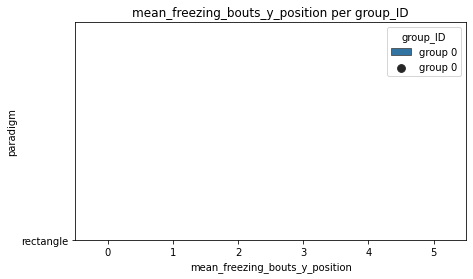

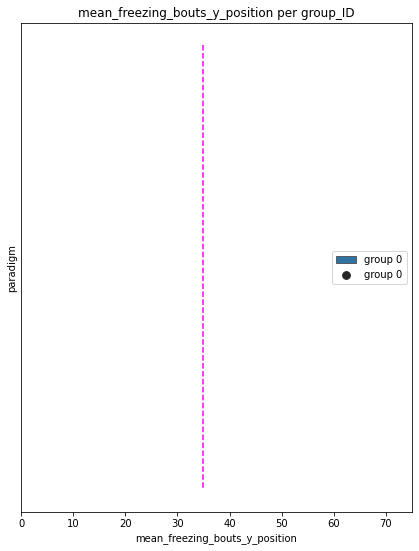

In [285]:
main()

In [203]:
#ersten frame bei setmazecorners schon zeigen bevor man Koordinaten aktualisiert (Frame von vornherein plotten)
#save figs
#style = style bei allen widgets mit langer description
#mehr variablen für Plots erstellen
#überflüssige variablen bei init funktionen rausstreichen
#trialnumber implementieren
#überflüssige VBoxes in Select Statistics löschen (oder FUnktionalität implementieren) , wenn select individual gewählt wurde
#all_files_there checken?

#combine cams func
#Inken d_data erstellen
#Funktionen Inken erstellen
#save analysed csvs
#reference coordinates?

In [ ]:
l_dfs_for_masterdf = []
l_freezing_bout_dfs = []
l_gait_disruption_bout_dfs = []
l_location_dfs = []

    l_rows_freezing = []
    # len of uniques is only 1 if there is no freezing (all are np.nan)
    if len(master_df['freezing_bout_count'].unique()) == 1:
        l_rows_freezing.append(master_df.iloc[0].to_frame().T)
    else:
        for freezing_bout_idx in master_df['freezing_bout_count'].unique():
            # To exclude the nan in the list of unique values
            if freezing_bout_idx >= 0:
                l_rows_freezing.append(master_df.loc[master_df['freezing_bout_count'] == freezing_bout_idx].iloc[0].to_frame().T)


    df_freezing_bouts = pd.concat(l_rows_freezing, axis=0)


    l_rows_gait_disruption = []
    # len of uniques is only 1 if there is no freezing (all are np.nan)
    if len(master_df['gaitdisruption_bout_count'].unique()) == 1:
        l_rows_gait_disruption.append(master_df.iloc[0].to_frame().T)    
    else:    
        for gait_disruption_bout_idx in master_df['gaitdisruption_bout_count'].unique():
            # To exclude nan
            if gait_disruption_bout_idx >= 0:
                l_rows_gait_disruption.append(master_df.loc[master_df['gaitdisruption_bout_count'] == gait_disruption_bout_idx].iloc[0].to_frame().T)

    df_gait_disruption_bouts = pd.concat(l_rows_gait_disruption, axis=0)

    
    
    l_frame_count = []
    l_avg_speed = []

    for lower_border in np.linspace(0,49.5,100):
        l_frame_count.append(master_df.loc[(master_df['CenterOfGravity_y_norm_cm'] >= lower_border) & 
                                           (master_df['CenterOfGravity_y_norm_cm'] < lower_border + 0.5)].shape[0])

        l_avg_speed.append(master_df.loc[(master_df['CenterOfGravity_y_norm_cm'] >= lower_border) & 
                                         (master_df['CenterOfGravity_y_norm_cm'] < lower_border + 0.5), 'CenterOfGravity_rolling_speed_px_per_s'].mean())

        
    d_location_df = {'subject_ID': [subject_ID]*100,
                    'group_ID': [group_ID]*100,
                    'paradigm': [paradigm]*100,
                    'trialnumber': [trial]*100,
                    'total_frames': [master_df.shape[0]]*100,
                    'distance_from_start_cm': np.linspace(0,49.5,100),
                    'frame_count': l_frame_count,
                    'average_speed': l_avg_speed}

    df_location = pd.DataFrame(d_location_df)
    
    l_freezing_bout_dfs.append(df_freezing_bouts)
    l_gait_disruption_bout_dfs.append(df_gait_disruption_bouts)
    l_location_dfs.append(df_location)
    
    # Save all results
    file_path_dicts = os.getcwd() + '/processed_dicts/'
    with open('{}{}_{}_{}_{}_processed_dict.p'.format(file_path_dicts, 'parkinsonian', subject_ID, paradigm, trial), 'wb') as io:
        pickle.dump(d_session_data, io, protocol=pickle.HIGHEST_PROTOCOL)
    
    file_path_dfs = os.getcwd() + '/master_dfs/'
    master_df.to_csv('{}{}_{}_{}_{}_master_df.csv'.format(file_path_dfs, 'parkinsonian', subject_ID, paradigm, trial))
    
    
    
df_all_freezing_bouts = pd.concat(l_freezing_bout_dfs)
df_all_freezing_bouts.reset_index(inplace=True, drop=True)
df_all_freezing_bouts.to_csv('master_freezing_bouts_df_{}.csv'.format('parkinsonian'))

df_all_gait_disruption_bouts = pd.concat(l_gait_disruption_bout_dfs)
df_all_gait_disruption_bouts.reset_index(inplace=True, drop=True)
df_all_gait_disruption_bouts.to_csv('master_gait_disruption_bouts_df_{}.csv'.format('parkinsonian'))

    
df_all_locations = pd.concat(l_location_dfs)
df_all_locations.reset_index(inplace=True, drop=True)
df_all_locations.to_csv('master_location_df_{}.csv'.format('parkinsonian'))